# Import all libraries needed

In [145]:
import os # For interacting with the operating system, such as file and directory operations.
import torch # The main PyTorch library for tensor operations and deep learning.
from torch.utils.data import DataLoader, Dataset #  Utilities for loading and batching data for training/testing.
from torchvision import transforms # Contains common image transformations and models.
from PIL import Image # Python Imaging Library for image processing.
import random # For generating random numbers, useful for shuffling data.
from torch import nn # Neural network module from PyTorch for building models.
import torch.optim as optim # Optimizers for training neural networks.
import matplotlib.pyplot as plt # For plotting graphs and images.
import seaborn as sns # For enhanced data visualization.
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score # Metrics for evaluating model performance.
import numpy as np # For numerical operations, especially with arrays.
from torchvision.transforms.functional import to_pil_image # For converting tensors to PIL images.
from torchvision.models import resnet18 # Pre-trained ResNet-18 model for image classification.

# Load Dataset and splitting

In [146]:
class LoadDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):  # constructor 
        self.root_dir = root_dir  
        self.transform = transform  
        self.classes = sorted(os.listdir(root_dir))  # get sorted list of class folders
        self.image_paths = []  
        self.labels = [] 
        
        for i, class_name in enumerate(self.classes):  # iterate over classes with index
            class_dir = os.path.join(root_dir, class_name)  # full path to class folder
            for subfolder in ['default', 'real_world']:  # loop over two subfolders
                subfolder_dir = os.path.join(class_dir, subfolder)  # path to subfolder
                image_names = os.listdir(subfolder_dir)  # list all image filenames
                random.shuffle(image_names)
                
                if split == 'train':  # first 60% images for training
                    image_names = image_names[:int(0.6 * len(image_names))]
                elif split == 'val':  #  60%-80% images for validation
                    image_names = image_names[int(0.6 * len(image_names)):int(0.8 * len(image_names))]
                else:  # split == 'test' last 20% images for testing
                    image_names = image_names[int(0.8 * len(image_names)):]
                
                for image_name in image_names:  
                    self.image_paths.append(os.path.join(subfolder_dir, image_name))  
                    self.labels.append(i)  # assign class index as label
    
    def __len__(self):  
        return len(self.image_paths)  # number of images in the WHOLE dataset
    
    def __getitem__(self, index):  
        image_path = self.image_paths[index]  # get image path by index
        label = self.labels[index]  # get label by index
        image = Image.open(image_path).convert('RGB')  # open image and convert to RGB
        
        if self.transform:  
            image = self.transform(image)
        
        return image, label  


# Building our custom CNN model

In [147]:

class Custom_CNN_Model(nn.Module):
    def __init__(self, waste_classes_nb):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)

        self.relu = nn.ReLU()
        self.maxpooling = nn.MaxPool2d(2, 2)

        # Adaptive average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers with dropout
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, waste_classes_nb)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, mod):
        mod = self.relu(self.conv1(mod))
        mod = self.maxpooling(mod)

        mod = self.relu(self.conv2(mod))
        mod = self.maxpooling(mod)

        mod = self.relu(self.conv3(mod))
        mod = self.maxpooling(mod)

        mod = self.relu(self.conv4(mod))
        mod = self.maxpooling(mod)

        mod = self.relu(self.conv5(mod))
        mod = self.maxpooling(mod)

        mod = self.avgpool(mod)
        mod = torch.flatten(mod, 1)

        mod = self.relu(self.fc1(mod))
        mod = self.dropout(mod)
        mod = self.fc2(mod)

        return mod


# Dataset path and hyperparameters

In [148]:
# Load dataset path
dataset_path = r'C:\Users\O.nabarawy\Desktop\AI Project\archive - smaller version\images\images'

# Set dataset hyperparameters
batch_size = 32
num_epochs = 25


In [149]:
# Create the datasets and data loaders
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),     # randomly flip images
    transforms.RandomRotation(10),         # small random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = LoadDataset(dataset_path, split='train', transform=train_transform)
val_dataset = LoadDataset(dataset_path, split='val', transform=val_test_transform)
test_dataset = LoadDataset(dataset_path, split='test', transform=val_test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [150]:
Waste_Classes = train_dataset.classes
print(Waste_Classes)

Waste_Classes_NB = len(Waste_Classes)
print(Waste_Classes_NB)

['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'disposable_plastic_cutlery', 'eggshells', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'styrofoam_cups', 'styrofoam_food_containers']
20


# Model training function

In [ ]:

def train_model_with_early_stopping(model, 
                                    train_dataloader, 
                                    val_dataloader, 
                                    train_dataset, 
                                    val_dataset, 
                                    criterion, 
                                    optimizer, 
                                    num_epochs, 
                                    patience=5, 
                                    device='cuda'):
    best_val_loss = float("inf")
    counter = 0

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train() 
        train_loss = 0.0

        for images, labels in train_dataloader:
            images = images.to(device) # Move images to the specified device (GPU/CPU)
            labels = labels.to(device)

            outputs = model(images) # Forward pass through the model
            loss = criterion(outputs, labels) # Calculate the loss

            optimizer.zero_grad() # Zero the gradients before backward pass
            loss.backward() # Backward pass to compute gradients
            optimizer.step() # Update model parameters

            train_loss += loss.item() * images.size(0) 

        train_loss /= len(train_dataset)
        train_losses.append(train_loss) 

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_dataloader: 
                images = images.to(device) # Move images to the specified device (GPU/CPU)
                labels = labels.to(device) 

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_dataset)
        val_losses.append(val_loss)

        # Early stopping check
        if val_loss < best_val_loss: 
            best_val_loss = val_loss 
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping.")
                print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
                break

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    print("Training completed!")
    return train_losses, val_losses


# Evaluating Model function

In [163]:
#  Evaluates a trained PyTorch model on a test set and visualizes performance.
def evaluate_model(model, test_dataloader, test_dataset, train_losses=None, val_losses=None, device='cuda'):

   
    model.to(device)
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1) # Get the predicted class indices
            y_true.extend(labels.cpu().numpy()) 
            y_pred.extend(preds.cpu().numpy())

    y_true = np.array(y_true) # Convert lists to numpy arrays for evaluation
    y_pred = np.array(y_pred)

    # Accuracy and F1 Score
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Overall Accuracy: {acc:.4f}")
    print(f"Macro-Averaged F1 Score: {f1:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 9))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', 
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel("Predicted") 
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Pie Chart: Correct vs Incorrect
    correct = np.sum(y_true == y_pred)
    incorrect = np.sum(y_true != y_pred)

    plt.figure(figsize=(5, 5))
    plt.pie([correct, incorrect], labels=["Correct", "Incorrect"],
            autopct='%1.1f%%', colors=["#4CAF50", "#F44336"])
    plt.title("Model Prediction Accuracy")
    plt.show()

    # Loss Plot
    if train_losses is not None and val_losses is not None:
        epochs = range(1, len(train_losses) + 1)
        plt.figure(figsize=(8, 5))
        plt.plot(epochs, train_losses, label='Training Loss')
        plt.plot(epochs, val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training vs. Validation Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Loss data (train_losses and val_losses) not provided. Loss plot skipped.")


# Visualizing and making predictions function

In [ ]:
#Visualizes a random sample's transformation pipeline and shows model predictions on 9 random test images.

def visualize_image_pipeline_and_predictions(model, test_dataset, device='cuda'):

    def denormalize(tensor_img):
        # Denormalizes the image tensor to convert it back to a PIL image
        tensor_img = tensor_img * 0.5 + 0.5
        return to_pil_image(tensor_img)

    # --- 1. IMAGE PIPELINE VISUALIZATION ---
    index = random.randint(0, len(test_dataset) - 1) 
    original_path = test_dataset.image_paths[index]
    original_image = Image.open(original_path).convert('RGB')

    transformed_image, label = test_dataset[index]

    plt.figure(figsize=(12, 4))
    
    # Original
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    # Resized (simulated)
    plt.subplot(1, 3, 2)
    resized_image = original_image.resize((224, 224))
    plt.imshow(resized_image)
    plt.title("Resized Image")
    plt.axis("off")

    # Transformed (normalized)
    plt.subplot(1, 3, 3)
    plt.imshow(denormalize(transformed_image.cpu()))
    plt.title("Transformed (Normalized)")
    plt.axis("off")

    plt.suptitle(f"Visualization of One Image Pipeline — Class: {test_dataset.classes[label]}")
    plt.tight_layout()
    plt.show()

    # --- 2. 3x3 GRID OF TEST IMAGES WITH PREDICTIONS ---
    model.eval() 
    indices = random.sample(range(len(test_dataset)), 9) # Randomly select 9 indices from the test dataset

    plt.figure(figsize=(12, 12))
    for i, idx in enumerate(indices):
        image_tensor, true_label = test_dataset[idx] # Get the image tensor and true label
        image = image_tensor.unsqueeze(0).to(device) # Add batch dimension and move to device (GPU)

        with torch.no_grad():
            output = model(image)
            pred_label = torch.argmax(output, dim=1).item() 

        display_img = denormalize(image_tensor) # Convert tensor back to PIL image for display

        plt.subplot(3, 3, i + 1)
        plt.imshow(display_img)
        color = "green" if pred_label == true_label else "red"
        plt.title(f"True: {test_dataset.classes[true_label]}\nPred: {test_dataset.classes[pred_label]}", color=color)
        plt.axis("off")

    plt.suptitle("Model Predictions on Random Test Images", fontsize=16)
    plt.tight_layout()
    plt.show()


# Custom_CNN_Model

In [154]:
model = Custom_CNN_Model(Waste_Classes_NB).to('cuda')   # Creates instance of the Custom_CNN_Model and move model to GPU
criterion = nn.CrossEntropyLoss()   # Loss function: measures how well the model’s predictions match the actual labels
optimizer = optim.Adam(model.parameters())    # Responsible for updating the model's parameters during training


# Train the model with early stopping
train_losses, val_losses = train_model_with_early_stopping(model, 
                                                            train_dataloader, 
                                                            val_dataloader, 
                                                            train_dataset, 
                                                            val_dataset, 
                                                            criterion, 
                                                            optimizer, 
                                                            num_epochs=num_epochs, 
                                                            patience=5, 
                                                            device='cuda')

Epoch [1/25], Train Loss: 2.8930, Val Loss: 2.7504
Epoch [2/25], Train Loss: 2.6505, Val Loss: 2.4376
Epoch [3/25], Train Loss: 2.4676, Val Loss: 2.2771
Epoch [4/25], Train Loss: 2.2900, Val Loss: 2.2168
Epoch [5/25], Train Loss: 2.1610, Val Loss: 1.9565
Epoch [6/25], Train Loss: 1.9354, Val Loss: 1.7295
Epoch [7/25], Train Loss: 1.7526, Val Loss: 1.6022
Epoch [8/25], Train Loss: 1.6022, Val Loss: 1.5096
Epoch [9/25], Train Loss: 1.4703, Val Loss: 1.3520
Epoch [10/25], Train Loss: 1.3088, Val Loss: 1.1465
Epoch [11/25], Train Loss: 1.2063, Val Loss: 1.1250
Epoch [12/25], Train Loss: 1.0617, Val Loss: 1.0428
Epoch [13/25], Train Loss: 0.9861, Val Loss: 0.9320
Epoch [14/25], Train Loss: 0.8821, Val Loss: 0.9544
Epoch [15/25], Train Loss: 0.7999, Val Loss: 0.7819
Epoch [16/25], Train Loss: 0.7259, Val Loss: 0.8885
Epoch [17/25], Train Loss: 0.6795, Val Loss: 0.7387
Epoch [18/25], Train Loss: 0.6232, Val Loss: 0.7208
Epoch [19/25], Train Loss: 0.5405, Val Loss: 0.6801
Epoch [20/25], Train 

Overall Accuracy: 0.8845
Macro-Averaged F1 Score: 0.8865

Classification Report:
                            precision    recall  f1-score   support

              aerosol_cans       0.87      0.94      0.90       100
        aluminum_food_cans       0.85      0.93      0.89       100
        aluminum_soda_cans       0.93      0.91      0.92       100
           cardboard_boxes       0.95      0.93      0.94       100
disposable_plastic_cutlery       0.97      0.96      0.96       100
                 eggshells       1.00      0.91      0.95       100
    glass_beverage_bottles       0.92      0.90      0.91       100
 glass_cosmetic_containers       0.95      0.95      0.95       100
           glass_food_jars       0.99      0.93      0.96       100
                paper_cups       0.71      0.94      0.81       100
          plastic_cup_lids       0.96      0.87      0.91       100
 plastic_detergent_bottles       1.00      0.56      0.72       100
   plastic_food_containers       0

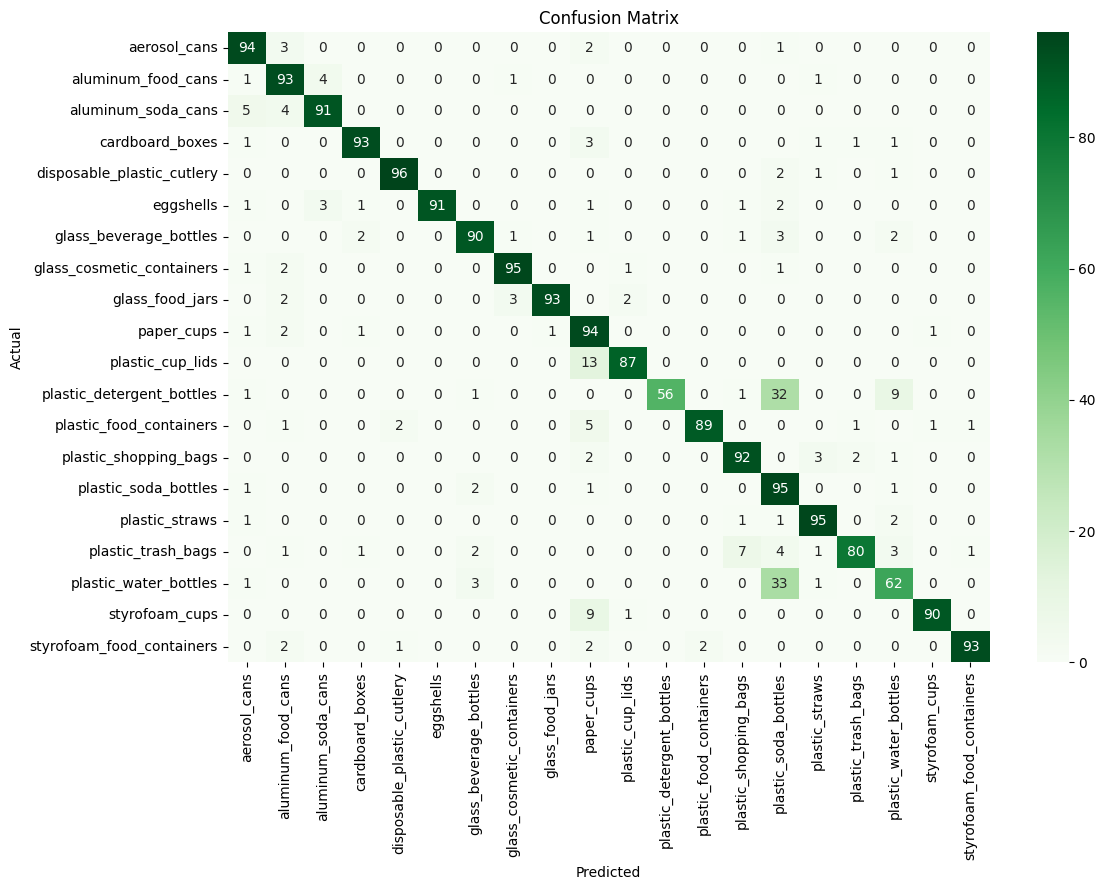

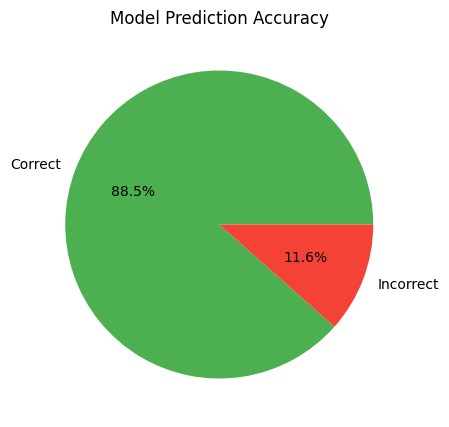

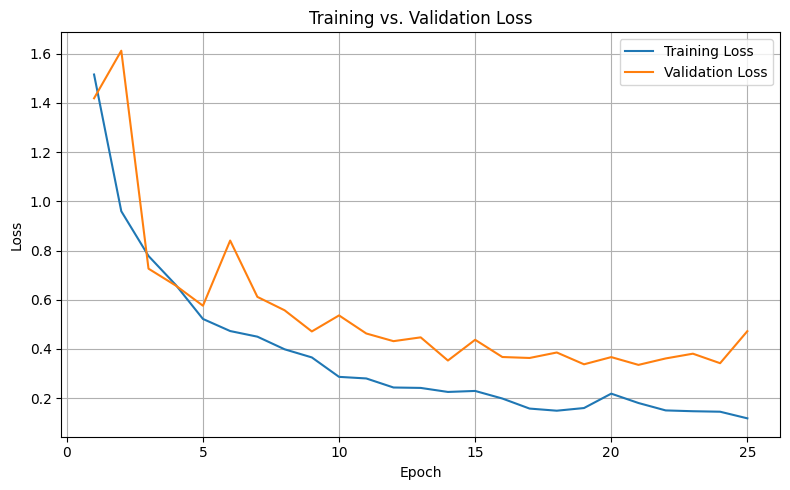

In [164]:
# Evaluate the model on the test set
evaluate_model(model, 
               test_dataloader, 
               test_dataset, 
               train_losses=train_losses, 
               val_losses=val_losses, 
               device='cuda')

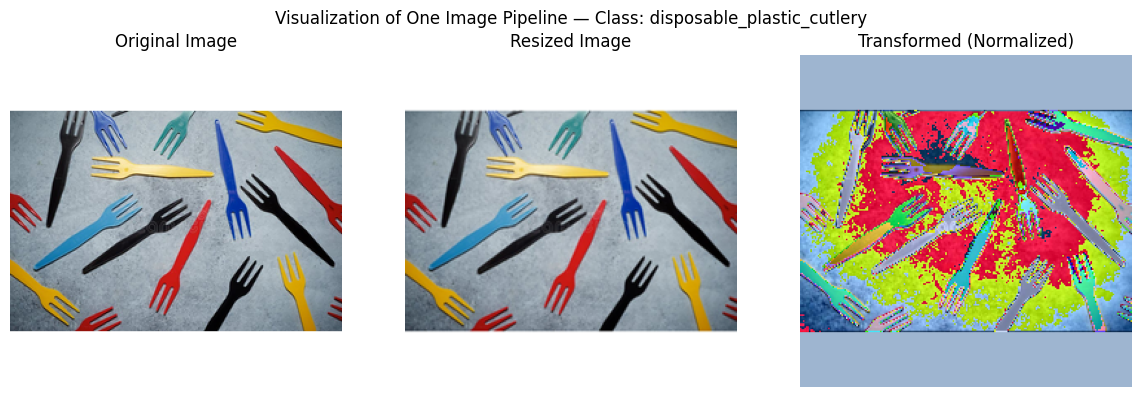

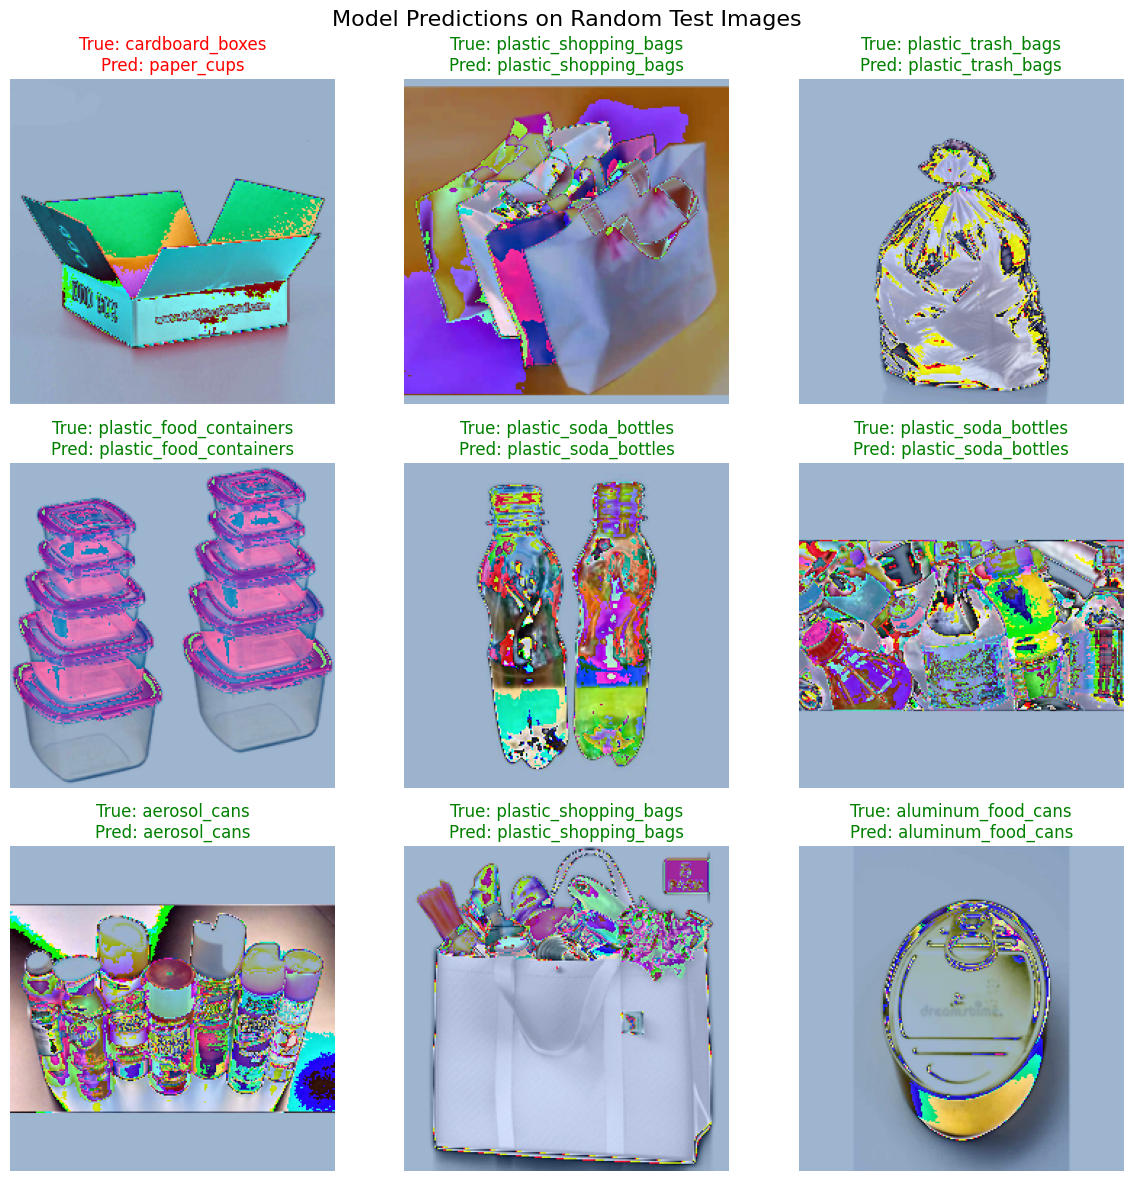

In [156]:
# Visualize the image pipeline and model predictions
visualize_image_pipeline_and_predictions(model, 
                                          test_dataset, 
                                          device='cuda')

# ResNet18 Model

In [157]:
# Define model ( ResNet)
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, Waste_Classes_NB)
model = model.to('cuda')

# Define criterion

#criterion = nn.CrossEntropyLoss()   DEFINED PREVIOUSLY IN THE CNN CUSTOM MODEL

# Define optimizer
optimizer = torch.optim.Adam(model.parameters())




C:\Users\O.nabarawy\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\O.nabarawy\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [158]:
# Train the model with early stopping
train_losses, val_losses = train_model_with_early_stopping(model, 
                                                            train_dataloader, 
                                                            val_dataloader, 
                                                            train_dataset, 
                                                            val_dataset, 
                                                            criterion, 
                                                            optimizer, 
                                                            num_epochs=num_epochs, 
                                                            patience=5, 
                                                            device='cuda')

Epoch [1/25], Train Loss: 1.5158, Val Loss: 1.4192
Epoch [2/25], Train Loss: 0.9599, Val Loss: 1.6126
Epoch [3/25], Train Loss: 0.7779, Val Loss: 0.7263
Epoch [4/25], Train Loss: 0.6603, Val Loss: 0.6576
Epoch [5/25], Train Loss: 0.5218, Val Loss: 0.5755
Epoch [6/25], Train Loss: 0.4726, Val Loss: 0.8406
Epoch [7/25], Train Loss: 0.4497, Val Loss: 0.6115
Epoch [8/25], Train Loss: 0.3984, Val Loss: 0.5570
Epoch [9/25], Train Loss: 0.3653, Val Loss: 0.4710
Epoch [10/25], Train Loss: 0.2863, Val Loss: 0.5362
Epoch [11/25], Train Loss: 0.2798, Val Loss: 0.4627
Epoch [12/25], Train Loss: 0.2430, Val Loss: 0.4314
Epoch [13/25], Train Loss: 0.2413, Val Loss: 0.4469
Epoch [14/25], Train Loss: 0.2249, Val Loss: 0.3527
Epoch [15/25], Train Loss: 0.2290, Val Loss: 0.4371
Epoch [16/25], Train Loss: 0.1981, Val Loss: 0.3670
Epoch [17/25], Train Loss: 0.1573, Val Loss: 0.3631
Epoch [18/25], Train Loss: 0.1486, Val Loss: 0.3854
Epoch [19/25], Train Loss: 0.1595, Val Loss: 0.3374
Epoch [20/25], Train 

Overall Accuracy: 0.8845
Macro-Averaged F1 Score: 0.8865

Classification Report:
                            precision    recall  f1-score   support

              aerosol_cans       0.87      0.94      0.90       100
        aluminum_food_cans       0.85      0.93      0.89       100
        aluminum_soda_cans       0.93      0.91      0.92       100
           cardboard_boxes       0.95      0.93      0.94       100
disposable_plastic_cutlery       0.97      0.96      0.96       100
                 eggshells       1.00      0.91      0.95       100
    glass_beverage_bottles       0.92      0.90      0.91       100
 glass_cosmetic_containers       0.95      0.95      0.95       100
           glass_food_jars       0.99      0.93      0.96       100
                paper_cups       0.71      0.94      0.81       100
          plastic_cup_lids       0.96      0.87      0.91       100
 plastic_detergent_bottles       1.00      0.56      0.72       100
   plastic_food_containers       0

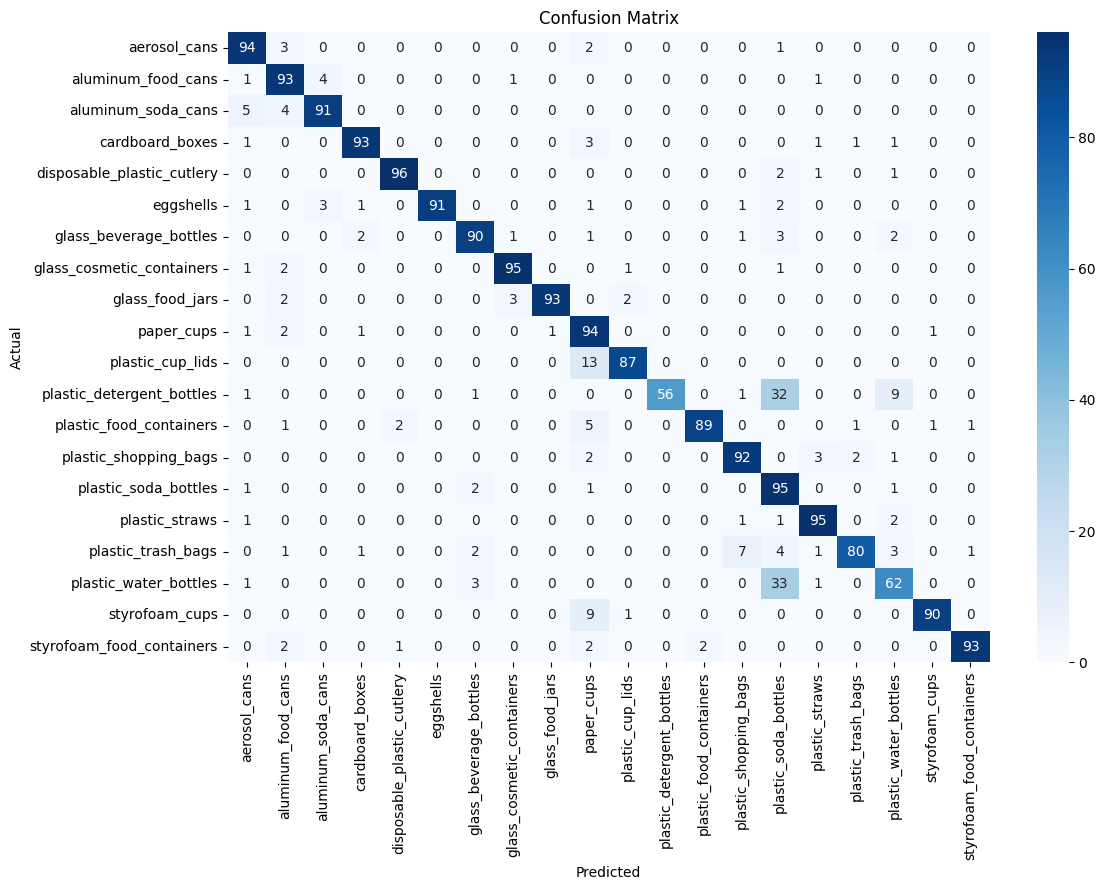

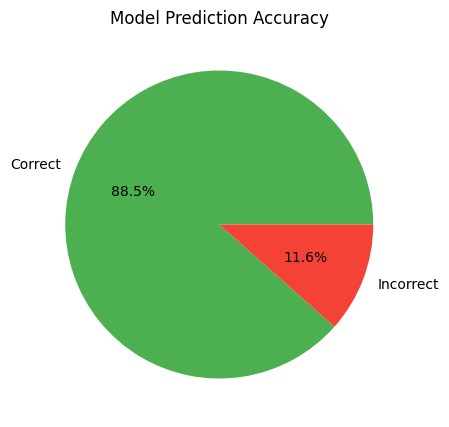

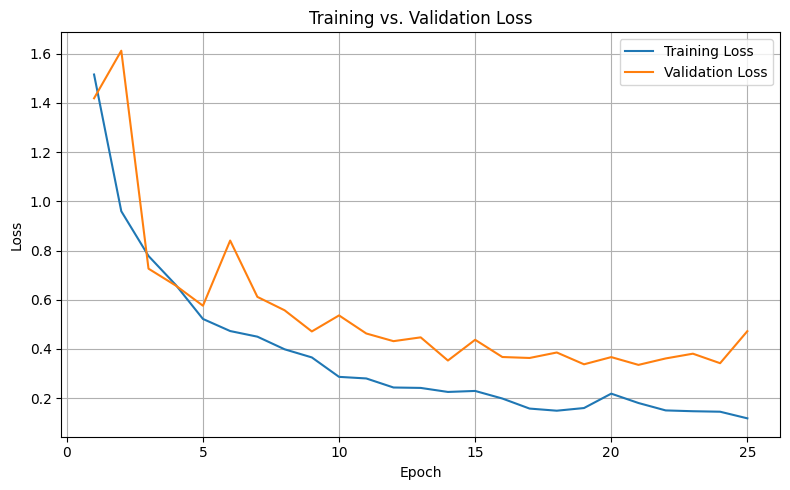

In [159]:
# Evaluate the model on the test set
evaluate_model(model, 
               test_dataloader, 
               test_dataset, 
               train_losses=train_losses, 
               val_losses=val_losses, 
               device='cuda')

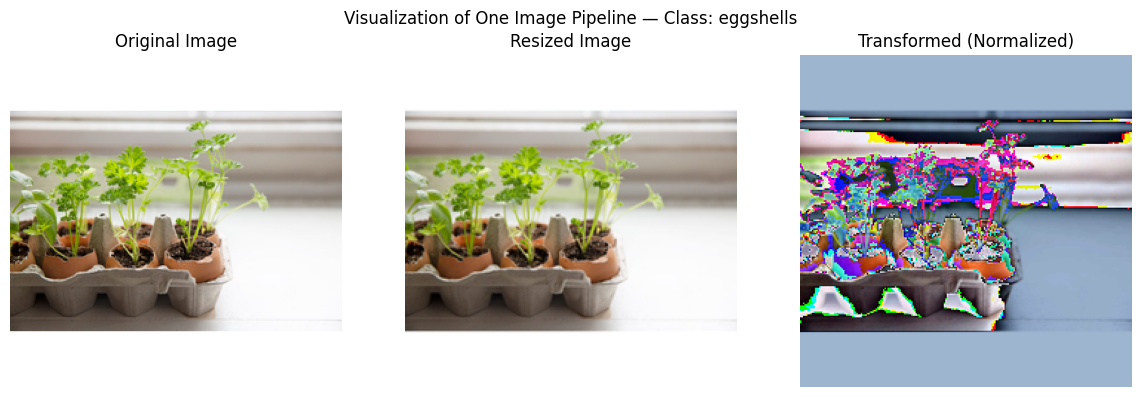

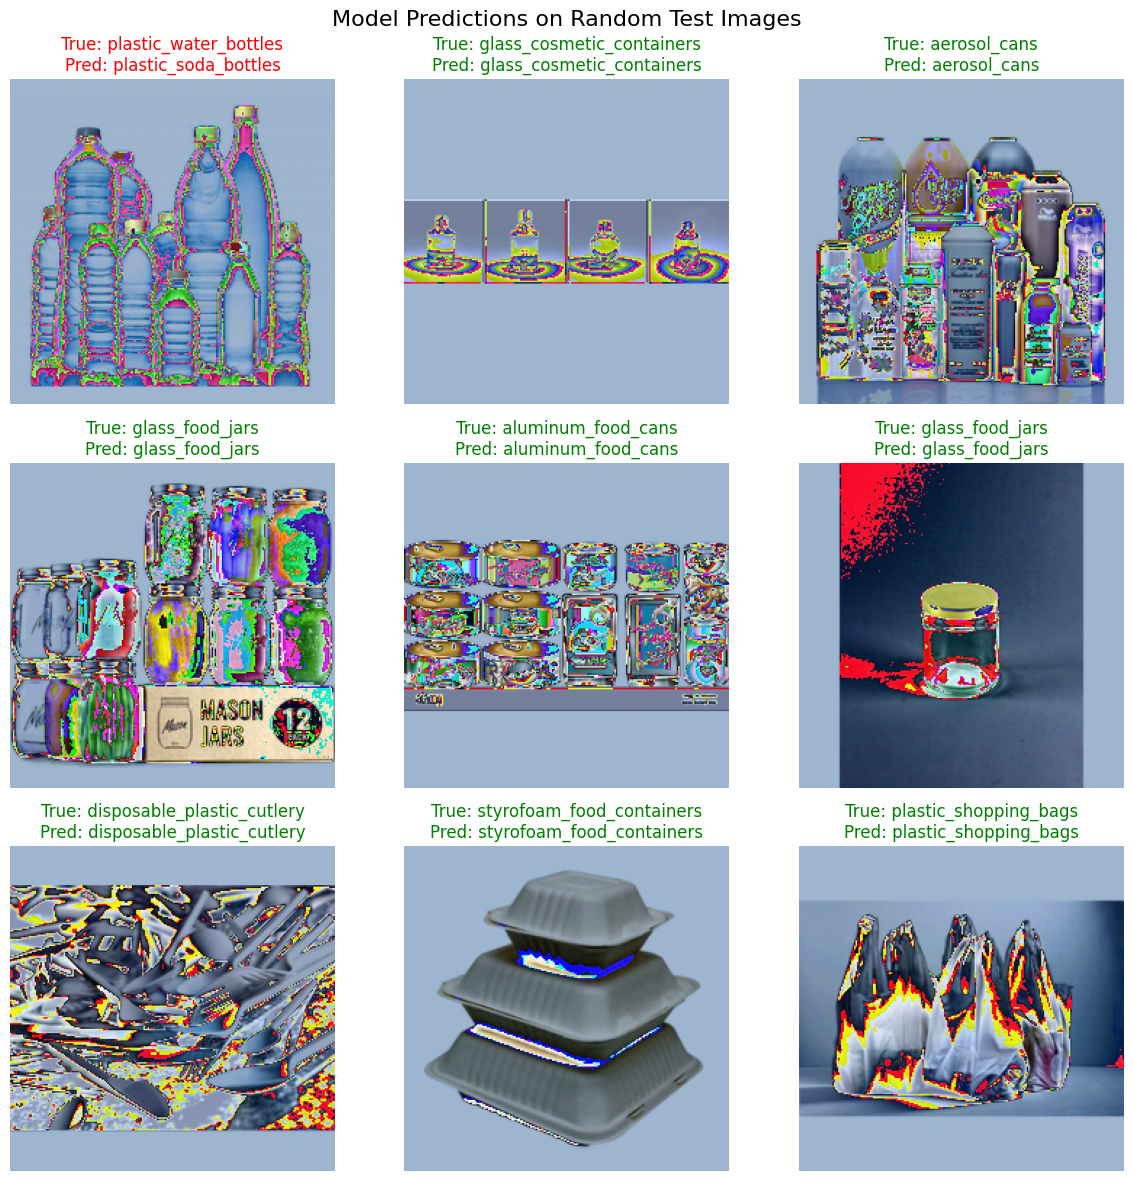

In [160]:
# Visualize the image pipeline and model predictions
visualize_image_pipeline_and_predictions(model, 
                                          test_dataset, 
                                          device='cuda')